In [6]:
import numpy as np
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm,binom
from scipy.io import loadmat
from scipy.special import digamma, gammaln, gamma
from numpy.linalg import inv
#import cv2
from scipy import ndimage
import tensorflow as tf

In [7]:
from keras.layers import Conv2D, BatchNormalization, Activation
from keras.models import Model, Input
from keras.optimizers import Adam
import keras.backend as K

In [8]:
# Output original images
images_gray = np.load('gray_scale.npy')


In [9]:
images_gray.shape

(25000, 224, 224)

In [5]:
# Generate the kernel required
kernel_size = 5
Kernel_num = 1
Kernel  = np.random.rand(kernel_size,kernel_size,Kernel_num)

In [6]:
# definition to project the kernel
def project_kernel(Kernel):
    Kernel_num = Kernel.shape[2]
    for i in range(Kernel_num):
        tmp = Kernel[:,:,i]
        if(np.linalg.norm(tmp,'fro')>0):
            Kernel[:,:,i]=Kernel[:,:,i]/np.linalg.norm(tmp,'fro')
        else:
            Kernel[:,:,i] = Kernel[:,:,i]
    return Kernel

In [7]:
A0 = project_kernel(Kernel)

In [8]:
images_conv = np.zeros_like(images_gray)

In [9]:
for i in range(images_conv.shape[0]):
    images_conv[i] = ndimage.convolve(images_gray[i], A0[:,:,0], mode='constant', cval=1.0)

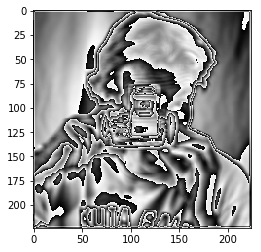

In [10]:
plt.imshow(images_conv[300],cmap='gray')
plt.show()

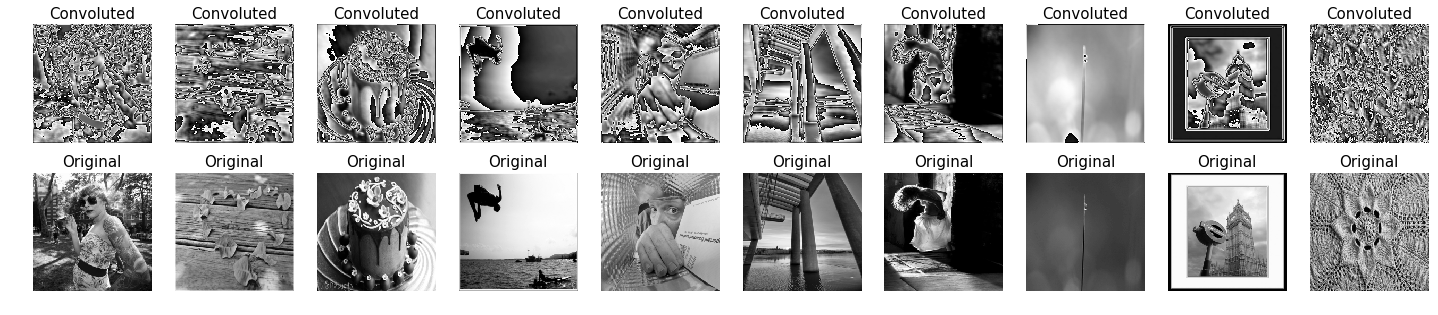

In [11]:
f, ax = plt.subplots(2,10,figsize=(25,5))
for i in range(10):
    ax[0,i].imshow(images_conv[i,:,:].astype('uint8'),cmap='gray');  ax[0,i].axis('Off'); ax[0,i].set_title('Convoluted', size=15)
    ax[1,i].imshow(images_gray[i,:,:].astype('uint8'),cmap='gray');  ax[1,i].axis('Off'); ax[1,i].set_title('Original', size=15)
plt.show()

In [12]:
for i in range(images_conv.shape[0]):
    images_conv[i] =images_conv[i]/255
    images_gray[i] =images_gray[i]/255

In [ ]:
num_train = 22000
num_val = 500
num_test = 2500

X_train = images_conv[:num_train]
Y_train = images_gray[:num_train]
X_val = images_conv[num_train:num_train+num_val]
Y_val = images_gray[num_train:num_train+num_val]
X_test = images_conv[num_train+num_val:]
Y_test = images_gray[num_train+num_val:]


X_train = X_train.reshape((22000,224,224,1))
Y_train = Y_train.reshape((22000,224,224,1))
X_val = X_val.reshape((500,224,224,1))
Y_val = Y_val.reshape((500,224,224,1))
X_test = X_test.reshape((2500,224,224,1))
Y_test = Y_test.reshape((2500,224,224,1))


In [ ]:
deblur_CNN_input = Input(shape=(224,224,1))

#HIDDEN LAYERS
deblur_CNN_layer1 = Conv2D(filters=16, kernel_size=7, strides = 1, padding='same')(deblur_CNN_input)
deblur_CNN_layer1 = BatchNormalization()(deblur_CNN_layer1)
deblur_CNN_layer1 = Activation('relu')(deblur_CNN_layer1)

deblur_CNN_layer2 = Conv2D(filters=16, kernel_size=5, strides = 1, padding='same')(deblur_CNN_layer1)
deblur_CNN_layer2 = BatchNormalization()(deblur_CNN_layer2)
deblur_CNN_layer2 = Activation('relu')(deblur_CNN_layer2)

deblur_CNN_layer3 = Conv2D(filters=16, kernel_size=5, strides = 1, padding='same')(deblur_CNN_layer2)
deblur_CNN_layer3 = BatchNormalization()(deblur_CNN_layer3)
deblur_CNN_layer3 = Activation('relu')(deblur_CNN_layer3)

deblur_CNN_output = Conv2D(filters=1, kernel_size=3, strides = 1, padding='same', activation='relu')(deblur_CNN_layer2)

deblur_CNN = Model(inputs= deblur_CNN_input, outputs=deblur_CNN_output )

In [ ]:
deblur_CNN.summary()

In [ ]:
adam = Adam(lr= 0.001)
deblur_CNN.compile(optimizer= adam, loss= 'mean_squared_error')

In [ ]:
deblur_CNN.fit(X_train, Y_train,batch_size = 256, epochs=5,validation_data=(X_val,Y_val))

In [ ]:
y_pred = deblur_CNN.predict(X_test[0:3])

In [ ]:
y_pred = y_pred*255